## Clone DALF repo

In [60]:
import sys
sys.path.append('../../DALF_CVPR_2023')

# Initialize DALF model

In [61]:
from modules.models.DALF import DALF_extractor as DALF
import torch
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
dalf = DALF(dev = device)

running DALF on cuda
[64, 64, 32, 1]
[64, 64, 32, 1]
backbone: 64 hardnet: 64
adding fusion layer...


# Match two frames with DALF features and display raw matches
For quick inference, please enable GPU on Colab.

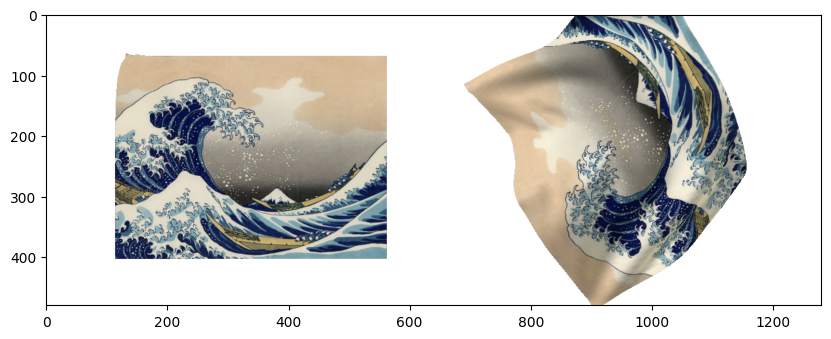

0.03121805191040039


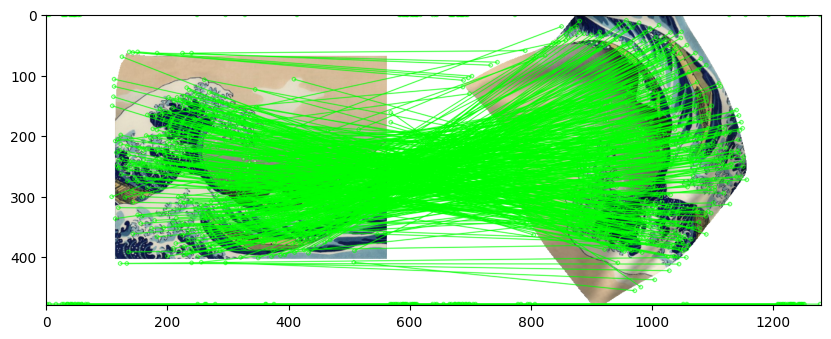

(<matplotlib.image.AxesImage at 0x7f97c11cd210>, None)

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import time

# img1 = cv2.imread('../assets/kanagawa_1.png')
# img2 = cv2.imread('../assets/kanagawa_2.png')
img1 = cv2.imread('../assets/kanagawa_1.png')
img2 = cv2.imread('../assets/kanagawa_2.png')

#display original imgs
plt.figure(figsize = (10,10))
plt.imshow(np.hstack([img1, img2])[..., ::-1]), plt.show()

#Compute kps and features
start_time = time.time()
kps1, descs1 = dalf.detectAndCompute(img1)
end_time = time.time()
print(end_time - start_time)
kps2, descs2 = dalf.detectAndCompute(img2)


#Match using vanilla opencv matcher
matcher = cv2.BFMatcher(crossCheck = True)
matches = matcher.match(descs1, descs2)

#Draw RAW matches
result = cv2.drawMatches(img1, kps1, img2, kps2, matches, None, matchColor = (0,255,0), matchesMask = None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(result[..., ::-1]), plt.show()

# Fit a TPS model and register the frames
Lets do better! We can refine the matches using Non-rigid RANSAC and fit a TPS model

## Obtain filtered matches

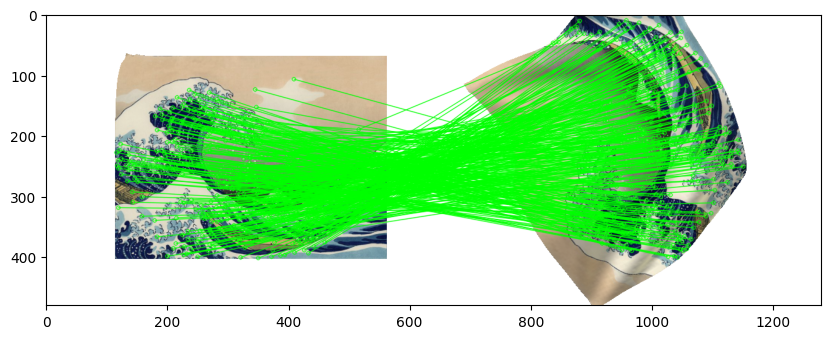

(<matplotlib.image.AxesImage at 0x7f97c10f5750>, None)

In [63]:
from modules.tps import RANSAC

src_pts = np.float32([kps1[m.queryIdx].pt for m in matches])
tgt_pts = np.float32([kps2[m.trainIdx].pt for m in matches])

#Computes non-rigid RANSAC
inliers = RANSAC.nr_RANSAC(src_pts, tgt_pts, device, thr = 0.2)

good_matches = [matches[i] for i in range(len(matches)) if inliers[i]]
#Draw filtered matches
result = cv2.drawMatches(img1, kps1, img2, kps2, good_matches, None, matchColor = (0,255,0), matchesMask = None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(result[..., ::-1]), plt.show()


## Use filtered matches to register a TPS model

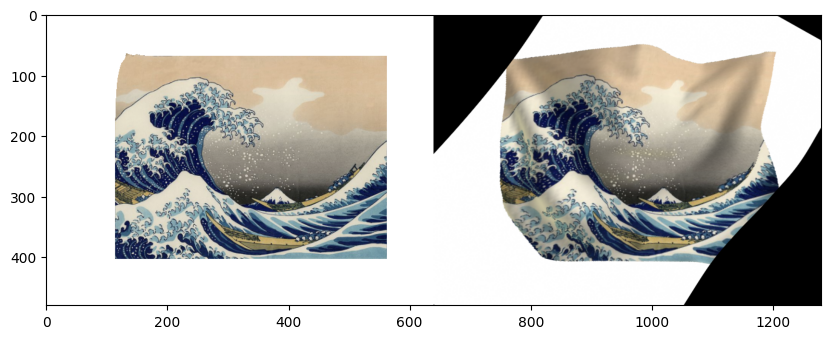

(<matplotlib.image.AxesImage at 0x7f97c1084e50>, None)

In [64]:
from modules.tps import pytorch as tps_pth
from modules.tps import numpy as tps_np
import torch.nn.functional as F
device = torch.device('cpu')
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

c_src = np.float32([kps1[m.queryIdx].pt for m in good_matches]) / np.float32([w1,h1])
c_dst = np.float32([kps2[m.trainIdx].pt for m in good_matches]) / np.float32([w2,h2])

def warp_image_cv(img, c_src, c_dst, dshape = None):
    img = torch.tensor(img).to(device).permute(2,0,1)[None, ...].float()
    dshape = dshape or img.shape
    theta = tps_np.tps_theta_from_points(c_src, c_dst, reduced=True, lambd=0.01)
    theta = torch.tensor(theta).to(device)[None, ...]
    grid = tps_pth.tps_grid(theta, torch.tensor(c_dst, device=device), dshape)
    #print(grid.shape, grid.dtype)
    img = F.grid_sample(img, grid)
    return img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)

#Warp deformed image (img2) into template
warped = warp_image_cv(img2, c_dst, c_src)
cv2.imwrite('5.jpg', warped)
result = np.hstack([img1, warped])
plt.figure(figsize = (10,10))
plt.imshow(result[..., ::-1]), plt.show()